# Rabi Oscillations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize

import logging


In [3]:
import qt3utils.experiments.rabi
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.rabi.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [6]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [7]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Instantiate an experiment object

In [12]:
experiment = qt3utils.experiments.rabi.Rabi(pulser, rfsynth, nidaq_config, 
                                            photon_counter_nidaq_terminal = 'PFI0',
                                            clock_nidaq_terminal = 'PFI12',
                                            rf_power = -20,
                                            rf_frequency=2872e6, 
                                            rf_width_step = 0.2e-6, 
                                            rf_width_low = 0.2e-6,
                                            rf_width_high = 10e-6,
                                            full_cycle_width = 30e-6)

In [13]:
experiment.experimental_conditions()

{'rf_width_low': 2e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -20,
 'rf_frequency': 2872000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'rf_response_time': 2e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'rf_pulse_justify': 'center',
 'full_cycle_width': 3e-05,
 'clock_period': 2e-07}

In [14]:
scan_data = experiment.run(N_cycles=50000)

INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.6e

# Observe the Data

In [15]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)

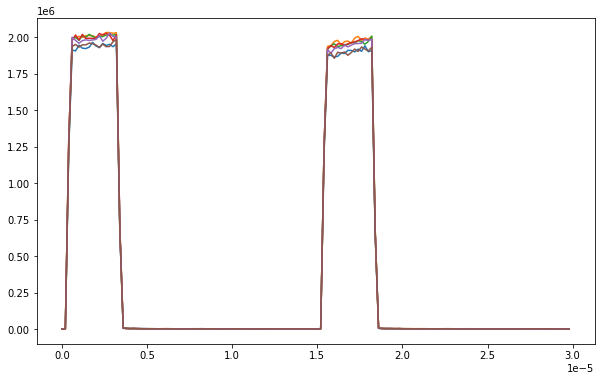

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

for scan in scan_data[::10]:
    
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = scan[0])
    
# for freq in list(combined_scans.keys())[::5]:
#     plot_trace(combined_scans[freq], cwodmr.N_cycles, clock_rate = 1./cwodmr.clock_period)

In [17]:
def get_trace(scan_data, width = 3e-6):
    widths = np.array([x[0] for x  in scan_data ])
    res_index = np.where(np.isclose(widths,width))
    scan = scan_data[int(res_index[0])]
    return scan

In [18]:
def plot_width(scan_data,   width = 3e-6):
    width, trace = get_trace(scan_data, width)
    plot_trace(trace, experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = width)

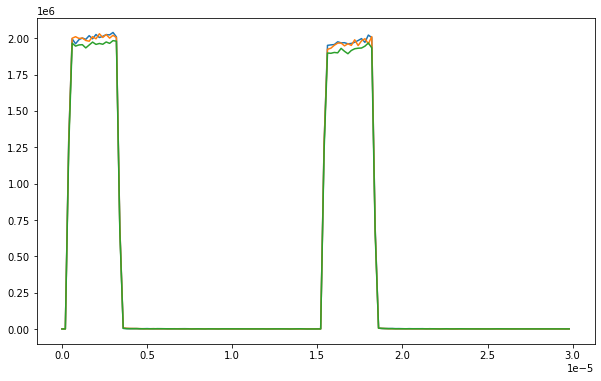

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

plot_width(scan_data, 1e-6)
plot_width(scan_data, 8e-6)
plot_width(scan_data, 10e-6)

# Analyze the Data

In [21]:
def lockin_amp_like_analysis(trace):
    #the first half is the background, second half is readout after RF pulse
    signal = trace[-len(trace)//2:]
    background = -1*trace[:len(trace)//2]
    return np.sum(signal) + np.sum(background)

def simple_signal_background(trace):
    signal = trace[-len(trace)//2:]
    background = trace[:len(trace)//2]
    return np.sum(signal)/np.sum(background)

def signal_to_background(trace, pre_trigger, experiment, duty = 1.0):
    signal = trace[-len(trace)//2:]
    background = trace[:len(trace)//2]
    
    signal = signal[pre_trigger:]
    background = background[pre_trigger:]
    
    aom_width = int(duty * experiment.aom_width/experiment.clock_period)
    return np.sum(signal[:aom_width])/np.sum(background[:aom_width])

# Build and Plot Contrast

Text(0.5, 0, 'width [s]')

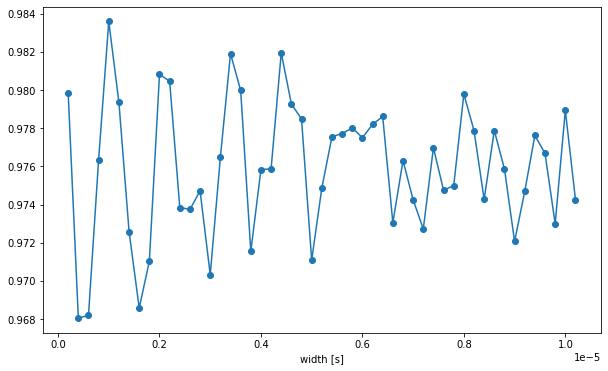

In [22]:
contrast = [(m[0], signal_to_background(m[1], 2, experiment)) for m in scan_data]
contrast = np.array(contrast)

x_data = contrast[:, 0]
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('width [s]')


## Change some parameters if you wish

In [43]:
experiment.experimental_conditions()

{'rf_width_low': 2e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -20,
 'rf_frequency': 2872000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'rf_response_time': 2e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'rf_pulse_justify': 'center',
 'full_cycle_width': 3e-05,
 'clock_period': 2e-07}

In [30]:
#modify these as you see fit

experiment.rf_power = -25
experiment.rf_width_step = 200e-9
experiment.aom_width = 5e-6
experiment.full_cycle_width = 40e-6

In [32]:
experiment.experimental_conditions()

{'rf_width_low': 2e-07,
 'rf_width_high': 1e-05,
 'rf_width_step': 2e-07,
 'rf_power': -25,
 'rf_frequency': 2872000000.0,
 'aom_width': 5e-06,
 'aom_response_time': 8e-07,
 'rf_response_time': 2e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'rf_pulse_justify': 'center',
 'full_cycle_width': 4e-05,
 'clock_period': 2e-07}

# Take Data

In [31]:
scan_data = experiment.run(N_cycles=50000)

INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.6e

# Build and Plot Contrast

Text(0.5, 0, 'width [microseconds]')

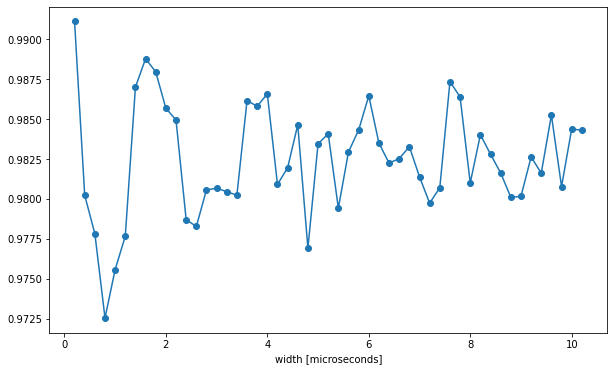

In [33]:
contrast = [(m[0], signal_to_background(m[1], 2, experiment)) for m in scan_data]
contrast = np.array(contrast)

x_data = contrast[:, 0]*1e6
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('width [microseconds]')


# Perform fit

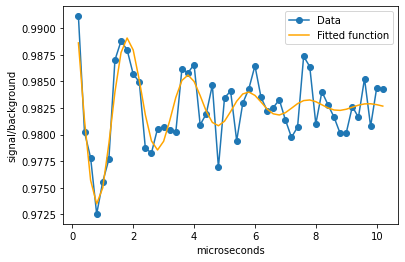

In [34]:
def rabi_oscillation(x, a, b, phi, t, offset, slope):
    return a * np.exp(-x/t) * np.sin(2*np.pi*x/b + phi) + offset + slope * x

params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data,
                                              p0=[.005, 1, 1, 1, 1, 0], maxfev=50000)
#params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data, maxfev=5000)


plt.figure(figsize=(6, 4))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('microseconds')
plt.ylabel('signal/background')
plt.plot(x_data, rabi_oscillation(x_data, *params),
         label='Fitted function', color='orange')
plt.legend()

In [35]:
params[1]/2 #pi pulse in microseconds

0.9908183332867327

In [36]:
params[3] #t2* in microseconds

2.4991542775700535

### Try slightly lower power

In [39]:
experiment.rf_power = -30
experiment.rf_width_step = 200e-9
experiment.aom_width = 5e-6
experiment.full_cycle_width = 40e-6

In [40]:
scan_data = experiment.run(N_cycles=50000)

INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.6e

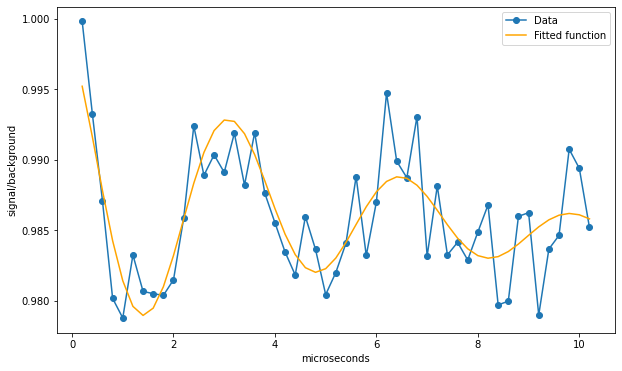

In [44]:
contrast = [(m[0], signal_to_background(m[1], 2, experiment)) for m in scan_data]
contrast = np.array(contrast)

x_data = contrast[:, 0]*1e6
y_data = contrast[:, 1]

plt.figure(figsize=(10, 6))

params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data,
                                              p0=[.005, 1, 1, 1, 1, 0], maxfev=50000)
#params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data, maxfev=5000)


#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('microseconds')
plt.ylabel('signal/background')
plt.plot(x_data, rabi_oscillation(x_data, *params),
         label='Fitted function', color='orange')
plt.legend()

In [45]:
params[1]/2 #pi pulse in microseconds

1.6950883423458787

In [46]:
params[3] #t2* in microseconds

4.986206524509054